# DreamFlow Local

## Intro

* **Date**: 12/5/2020
* **What**: This is the DreamFlow algorithm, but neurons are connected to spatially local regions of the input and compete locally.  This should hopefully allow the neurons to find important local structures.  
* **Why**: I think that the only way we're going to see an improvement in classification accuracy is if the network understands the structures it witnesses in terms of its local characteristics and substructures.
* **Hopes**: That this architecture finds good local structures.
* **Limitations**: DreamFlow didn't work last time, so there's no reason to expect that this will be any better.  

## Code

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from time import sleep, time

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x / 255.0, test_x / 255.0

L = 28 * 28

flat_x = train_x.reshape(-1, L)
flat_test = test_x.reshape(-1, L)

def draw_weights(w, Kx, Ky, fig):
    tapestry = np.zeros((28 * Ky, 28 * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * 28: (y + 1) * 28, x * 28: (x + 1) * 28] = w[w_i].reshape(28, 28)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Reds", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [8]:
def dream_classifier(w1, w2, w3, flat_test, test_y, c_i, N1, N2, Ky):
    # Calculate layer values
    v_w1 = flat_test @ w1
    
    B = flat_test.shape[0]

    l1_clusters = v_w1 * c_i

    l1_wins = np.argmax(l1_clusters, axis=2).T
    l1_mask = np.zeros((B, N1))
    l1_mask[np.repeat(np.arange(B), Ky), l1_wins.reshape(1, -1)] = 1

    l1 = v_w1 * l1_mask

    l2_b = l1 @ w2

    l2_wins = np.argmax(l2_b, axis=1)
    l2_mask = np.zeros((B, N2))
    l2_mask[np.arange(B), l2_wins] = 1

    l2 = l2_b * l2_mask
    
    pred = np.argmax(l2 @ w3.T, axis=1)
    
    num_inputs = pred.shape[0]
    
    correct = np.zeros(num_inputs)
    
    correct[pred == test_y] = 1
    
    accuracy = np.sum(correct) / num_inputs
    
    print("Accuracy: ", str(100 * accuracy) + '%')
    
    return accuracy
    


In [9]:
# C_s is the number of neurons in each local cluster.  There are 13 local clusters.
def dream_flow_local(T_s, C_s, flat_x, train_y, Nep, B, prec, xi, N2, fig):
    num_clusters = 13
    
    N1 = C_s * num_clusters
    L = flat_x.shape[1]
    
    # Create classification inputs
    clsfn_in = np.zeros((T_s, num_classes))
    clsfn_in[np.arange(T_s), train_y[:T_s]] = 1

    # Initialize competition layers
    c_i = np.zeros((num_clusters, N1))

    for i in range(num_clusters):
        c_i[i, i * C_s : (i + 1) * C_s] = 1

    c_i = c_i.reshape(num_clusters, 1, -1)

    # Intialize weight matrices
    w1 = np.zeros((L, N1))
    
    w_i = 0
    for x in range(3):
        for y in range(3):
            for n in range(C_s):
                w_c = np.zeros((28, 28))
                w_c[y * 9: (y + 1) * 9, x * 9: (x + 1) * 9] = np.random.uniform(0, 1, (9, 9))

                w1[:, w_i] = w_c.reshape(-1)

                w_i += 1


    for x in range(2):
        for y in range(2):
            for n in range(C_s):
                w_c = np.zeros((28, 28))
                w_c[(y * 9) + 4: ((y + 1) * 9) + 4, (x * 9) + 4: ((x + 1) * 9) + 4] = np.random.uniform(0, 1, (9, 9))

                w1[:, w_i] = w_c.reshape(-1)

                w_i += 1
    
    w2 = np.random.uniform(0, 1, (N1, N2))
    w3 = np.random.uniform(0, 1, (num_classes, N2))

    inputs = flat_x[:T_s]

    for ep in range(Nep):
        for i in tqdm(range(T_s//B)):
            #Get inputs
            v = inputs[i * B: (i + 1) * B]
            cl = clsfn_in[i * B: (i + 1) * B]

            # Calculate layer values
            v_w1 = v @ w1

            l1_clusters = v_w1 * c_i

            l1_wins = np.argmax(l1_clusters, axis=2).T
            l1_mask = np.zeros((B, N1))
            l1_mask[np.repeat(np.arange(B), num_clusters), l1_wins.reshape(1, -1)] = 1

            l1 = v_w1 * l1_mask

            l1_w2 = l1 @ w2
            cl_w3 = cl @ w3

            l2_b = l1_w2 + cl_w3

            l2_wins = np.argmax(l2_b, axis=1)
            l2_mask = np.zeros((B, N2))
            l2_mask[np.arange(B), l2_wins] = 1

            l2 = l2_b * l2_mask

            # Make adjustments to weight matrices

            # Start with w2
            l1_pred = l2 @ w2.T
            l1_pred_mask = np.where(l1_pred > prec, l1_pred, 1)
            l1_err = (l1 - l1_pred) / l1_pred_mask

            dw2_base = w2 * l2.reshape(B, 1, -1)
            dw2 = np.sum(dw2_base * l1_err.reshape(B, -1, 1), axis=0)

            max_dw2 = np.max(np.abs(dw2))
            if max_dw2 < prec:
                max_dw2 = prec

            w2 += (xi / max_dw2) * dw2

            # Now classification
            cl_pred = l2 @ w3.T
            cl_pred_mask = np.where(cl_pred > prec, cl_pred, 1)
            cl_err = (cl - cl_pred) / cl_pred_mask

            dw3_base = w3 * l2.reshape(B, 1, -1)
            dw3 = np.sum(dw3_base * cl_err.reshape(B, -1, 1), axis=0)

            max_dw3 = np.max(np.abs(dw3))
            if max_dw3 < prec:
                max_dw3 = prec

            w3 += (xi / max_dw3) * dw3

            # Finally, w1
            v_pred = l1 @ w1.T
            v_pred_mask = np.where(v_pred > prec, v_pred, 1)
            v_err = (v - v_pred) / v_pred_mask

            dw1_base = w1 * l1.reshape(B, 1, -1)
            dw1 = np.sum(dw1_base * v_err.reshape(B, -1, 1), axis=0)

            max_dw1 = np.max(np.abs(dw1))
            if max_dw1 < prec:
                max_dw1 = prec

            w1 += (xi / max_dw1) * dw1

        draw_weights(w1.T, C_s, 13, fig)
        
    dream_classifier(w1, w2, w3, flat_test, test_y, c_i, N1, N2, num_clusters)

<IPython.core.display.Javascript object>


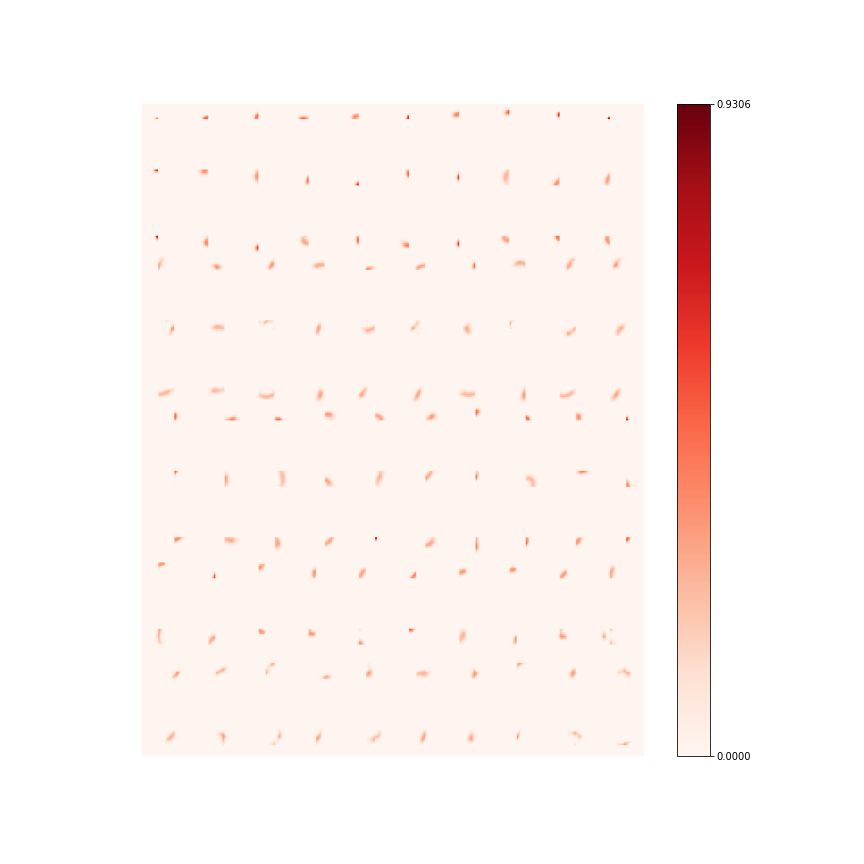

100%|███████████████████████████████████████████████████████████████| 600/600 [01:05<00:00,  9.08it/s]


Accuracy:  69.07%


<IPython.core.display.Javascript object>


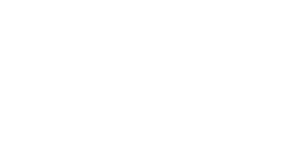

In [33]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

T_s = 60000 
Nep = 10
num_classes = 10
L = flat_x.shape[1]
B = 100 # Batch size
prec = 1e-20 # The smallest number I'm allowing
xi = 0.01

# This is the number of neurons in the second hidden layer
N2 = 100

C_s = 10

dream_flow_local(T_s, C_s, flat_x, train_y, Nep, B, prec, xi, N2, fig)

Well, there's nothing to call that but irritating.  Only 70%.  Bah!  I'm going to try running this without overlap in the blocks and see if that helps.  Then I'm going to try more neurons per cluster.

In [10]:
# C_s is the number of neurons in each local cluster.  There are 13 local clusters.
def dream_flow_local_block(T_s, C_s, flat_x, train_y, Nep, B, prec, xi, N2, fig):
    num_clusters = 9
    
    N1 = C_s * num_clusters
    L = flat_x.shape[1]
    
    # Create classification inputs
    clsfn_in = np.zeros((T_s, num_classes))
    clsfn_in[np.arange(T_s), train_y[:T_s]] = 1

    # Initialize competition layers
    c_i = np.zeros((num_clusters, N1))

    for i in range(num_clusters):
        c_i[i, i * C_s : (i + 1) * C_s] = 1

    c_i = c_i.reshape(num_clusters, 1, -1)

    # Intialize weight matrices
    w1 = np.zeros((L, N1))
    
    w_i = 0
    for x in range(3):
        for y in range(3):
            for n in range(C_s):
                w_c = np.zeros((28, 28))
                w_c[y * 9: (y + 1) * 9, x * 9: (x + 1) * 9] = np.random.uniform(0, 1, (9, 9))

                w1[:, w_i] = w_c.reshape(-1)

                w_i += 1

    
    w2 = np.random.uniform(0, 1, (N1, N2))
    w3 = np.random.uniform(0, 1, (num_classes, N2))

    inputs = flat_x[:T_s]

    for ep in range(Nep):
        for i in tqdm(range(T_s//B)):
            #Get inputs
            v = inputs[i * B: (i + 1) * B]
            cl = clsfn_in[i * B: (i + 1) * B]

            # Calculate layer values
            v_w1 = v @ w1

            l1_clusters = v_w1 * c_i

            l1_wins = np.argmax(l1_clusters, axis=2).T
            l1_mask = np.zeros((B, N1))
            l1_mask[np.repeat(np.arange(B), num_clusters), l1_wins.reshape(1, -1)] = 1

            l1 = v_w1 * l1_mask

            l1_w2 = l1 @ w2
            cl_w3 = cl @ w3

            l2_b = l1_w2 + cl_w3

            l2_wins = np.argmax(l2_b, axis=1)
            l2_mask = np.zeros((B, N2))
            l2_mask[np.arange(B), l2_wins] = 1

            l2 = l2_b * l2_mask

            # Make adjustments to weight matrices

            # Start with w2
            l1_pred = l2 @ w2.T
            l1_pred_mask = np.where(l1_pred > prec, l1_pred, 1)
            l1_err = (l1 - l1_pred) / l1_pred_mask

            dw2_base = w2 * l2.reshape(B, 1, -1)
            dw2 = np.sum(dw2_base * l1_err.reshape(B, -1, 1), axis=0)

            max_dw2 = np.max(np.abs(dw2))
            if max_dw2 < prec:
                max_dw2 = prec

            w2 += (xi / max_dw2) * dw2

            # Now classification
            cl_pred = l2 @ w3.T
            cl_pred_mask = np.where(cl_pred > prec, cl_pred, 1)
            cl_err = (cl - cl_pred) / cl_pred_mask

            dw3_base = w3 * l2.reshape(B, 1, -1)
            dw3 = np.sum(dw3_base * cl_err.reshape(B, -1, 1), axis=0)

            max_dw3 = np.max(np.abs(dw3))
            if max_dw3 < prec:
                max_dw3 = prec

            w3 += (xi / max_dw3) * dw3

            # Finally, w1
            v_pred = l1 @ w1.T
            v_pred_mask = np.where(v_pred > prec, v_pred, 1)
            v_err = (v - v_pred) / v_pred_mask

            dw1_base = w1 * l1.reshape(B, 1, -1)
            dw1 = np.sum(dw1_base * v_err.reshape(B, -1, 1), axis=0)

            max_dw1 = np.max(np.abs(dw1))
            if max_dw1 < prec:
                max_dw1 = prec

            w1 += (xi / max_dw1) * dw1

        draw_weights(w1.T, C_s, num_clusters, fig)
        
    dream_classifier(w1, w2, w3, flat_test, test_y, c_i, N1, N2, num_clusters)

<IPython.core.display.Javascript object>


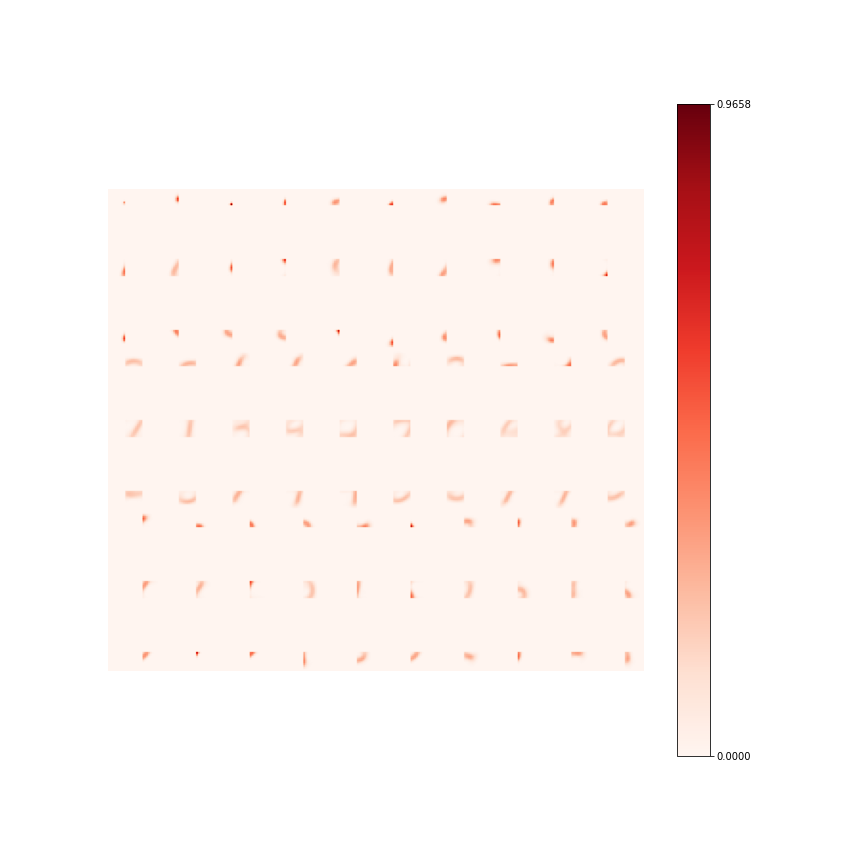

100%|███████████████████████████████████████████████████████████████| 600/600 [00:55<00:00, 10.84it/s]


Accuracy:  68.17999999999999%


<IPython.core.display.Javascript object>


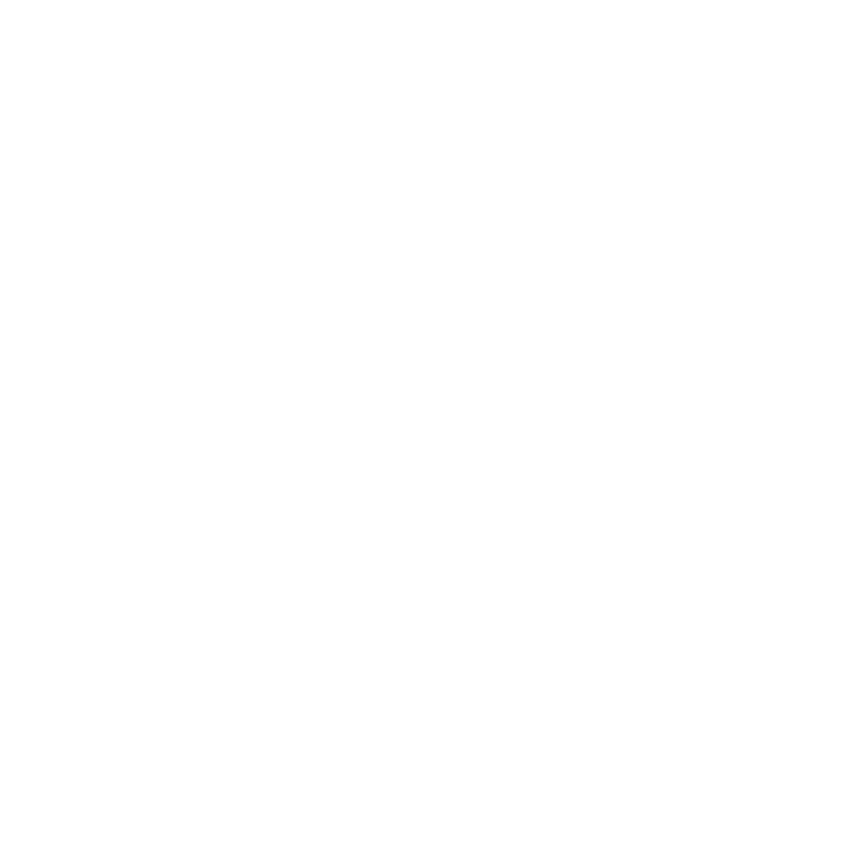

In [39]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))

T_s = 60000 
Nep = 10
num_classes = 10
L = flat_x.shape[1]
B = 100 # Batch size
prec = 1e-20 # The smallest number I'm allowing
xi = 0.01

# This is the number of neurons in the second hidden layer
N2 = 100

C_s = 10

dream_flow_local_block(T_s, C_s, flat_x, train_y, Nep, B, prec, xi, N2, fig)

Interesting.  Only slightly worse.  I'm going pump up both the number of neurons in each cluster, and the number of neurons in the second, fully competitive layer.

<IPython.core.display.Javascript object>


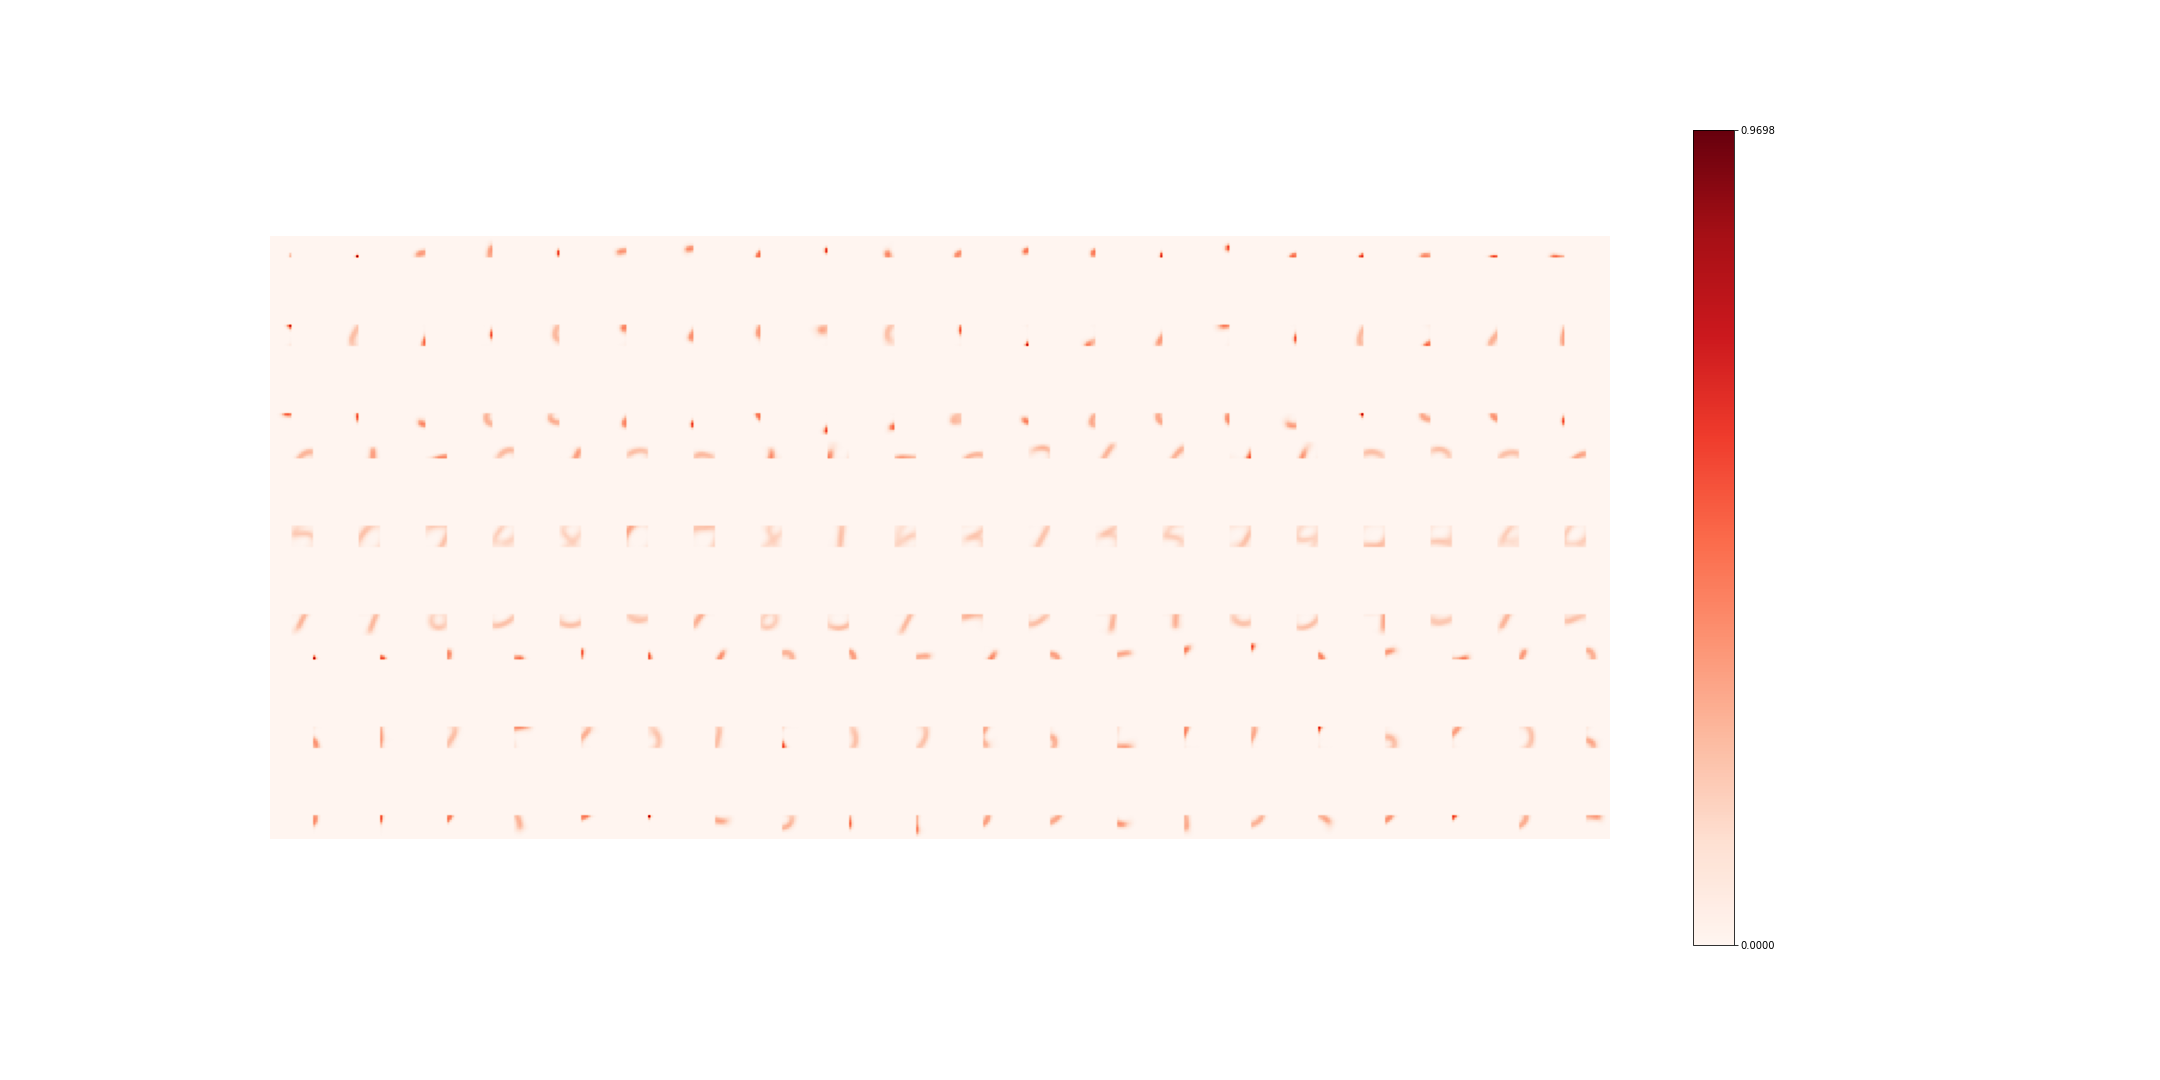

100%|███████████████████████████████████████████████████████████████| 600/600 [01:40<00:00,  5.97it/s]


Accuracy:  73.34%


<IPython.core.display.Javascript object>


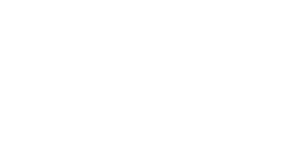

In [43]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(30, 15))

T_s = 60000 
Nep = 10
num_classes = 10
L = flat_x.shape[1]
B = 100 # Batch size
prec = 1e-20 # The smallest number I'm allowing
xi = 0.01

# This is the number of neurons in the second hidden layer
N2 = 200

C_s = 20

dream_flow_local_block(T_s, C_s, flat_x, train_y, Nep, B, prec, xi, N2, fig)

I really dislike that.  I'm going to see if I can speed this up with tf numpy.

In [1]:
import tensorflow.experimental.numpy as tnp

In [4]:
# C_s is the number of neurons in each local cluster.  There are 13 local clusters.
def df_local_block_tnp(T_s, C_s, flat_x, train_y, Nep, B, prec, xi, N2, fig):
    num_clusters = 9
    
    N1 = C_s * num_clusters
    L = flat_x.shape[1]
    
    # Create classification inputs
    clsfn_in = tnp.zeros((T_s, num_classes))
    clsfn_in[tnp.arange(T_s), train_y[:T_s]] = 1

    # Initialize competition layers
    c_i = tnp.zeros((num_clusters, N1))

    for i in range(num_clusters):
        c_i[i, i * C_s : (i + 1) * C_s] = 1

    c_i = c_i.reshape(num_clusters, 1, -1)

    # Intialize weight matrices
    w1 = tnp.zeros((L, N1))
    
    w_i = 0
    for x in range(3):
        for y in range(3):
            for n in range(C_s):
                w_c = tnp.zeros((28, 28))
                w_c[y * 9: (y + 1) * 9, x * 9: (x + 1) * 9] = tnp.random.uniform(0, 1, (9, 9))

                w1[:, w_i] = w_c.reshape(-1)

                w_i += 1

    
    w2 = tnp.random.uniform(0, 1, (N1, N2))
    w3 = tnp.random.uniform(0, 1, (num_classes, N2))

    inputs = flat_x[:T_s]

    for ep in range(Nep):
        for i in tqdm(range(T_s//B)):
            #Get inputs
            v = inputs[i * B: (i + 1) * B]
            cl = clsfn_in[i * B: (i + 1) * B]

            # Calculate layer values
            v_w1 = v @ w1

            l1_clusters = v_w1 * c_i

            l1_wins = tnp.argmax(l1_clusters, axis=2).T
            l1_mask = tnp.zeros((B, N1))
            l1_mask[tnp.repeat(tnp.arange(B), num_clusters), l1_wins.reshape(1, -1)] = 1

            l1 = v_w1 * l1_mask

            l1_w2 = l1 @ w2
            cl_w3 = cl @ w3

            l2_b = l1_w2 + cl_w3

            l2_wins = tnp.argmax(l2_b, axis=1)
            l2_mask = tnp.zeros((B, N2))
            l2_mask[tnp.arange(B), l2_wins] = 1

            l2 = l2_b * l2_mask

            # Make adjustments to weight matrices

            # Start with w2
            l1_pred = l2 @ w2.T
            l1_pred_mask = tnp.where(l1_pred > prec, l1_pred, 1)
            l1_err = (l1 - l1_pred) / l1_pred_mask

            dw2_base = w2 * l2.reshape(B, 1, -1)
            dw2 = tnp.sum(dw2_base * l1_err.reshape(B, -1, 1), axis=0)

            max_dw2 = tnp.max(tnp.abs(dw2))
            if max_dw2 < prec:
                max_dw2 = prec

            w2 += (xi / max_dw2) * dw2

            # Now classification
            cl_pred = l2 @ w3.T
            cl_pred_mask = tnp.where(cl_pred > prec, cl_pred, 1)
            cl_err = (cl - cl_pred) / cl_pred_mask

            dw3_base = w3 * l2.reshape(B, 1, -1)
            dw3 = tnp.sum(dw3_base * cl_err.reshape(B, -1, 1), axis=0)

            max_dw3 = tnp.max(np.abs(dw3))
            if max_dw3 < prec:
                max_dw3 = prec

            w3 += (xi / max_dw3) * dw3

            # Finally, w1
            v_pred = l1 @ w1.T
            v_pred_mask = tnp.where(v_pred > prec, v_pred, 1)
            v_err = (v - v_pred) / v_pred_mask

            dw1_base = w1 * l1.reshape(B, 1, -1)
            dw1 = tnp.sum(dw1_base * v_err.reshape(B, -1, 1), axis=0)

            max_dw1 = tnp.max(np.abs(dw1))
            if max_dw1 < prec:
                max_dw1 = prec

            w1 += (xi / max_dw1) * dw1

        draw_weights(w1.T, C_s, num_clusters, fig)
        
    dream_classifier(w1, w2, w3, flat_test, test_y, c_i, N1, N2, num_clusters)

<IPython.core.display.Javascript object>


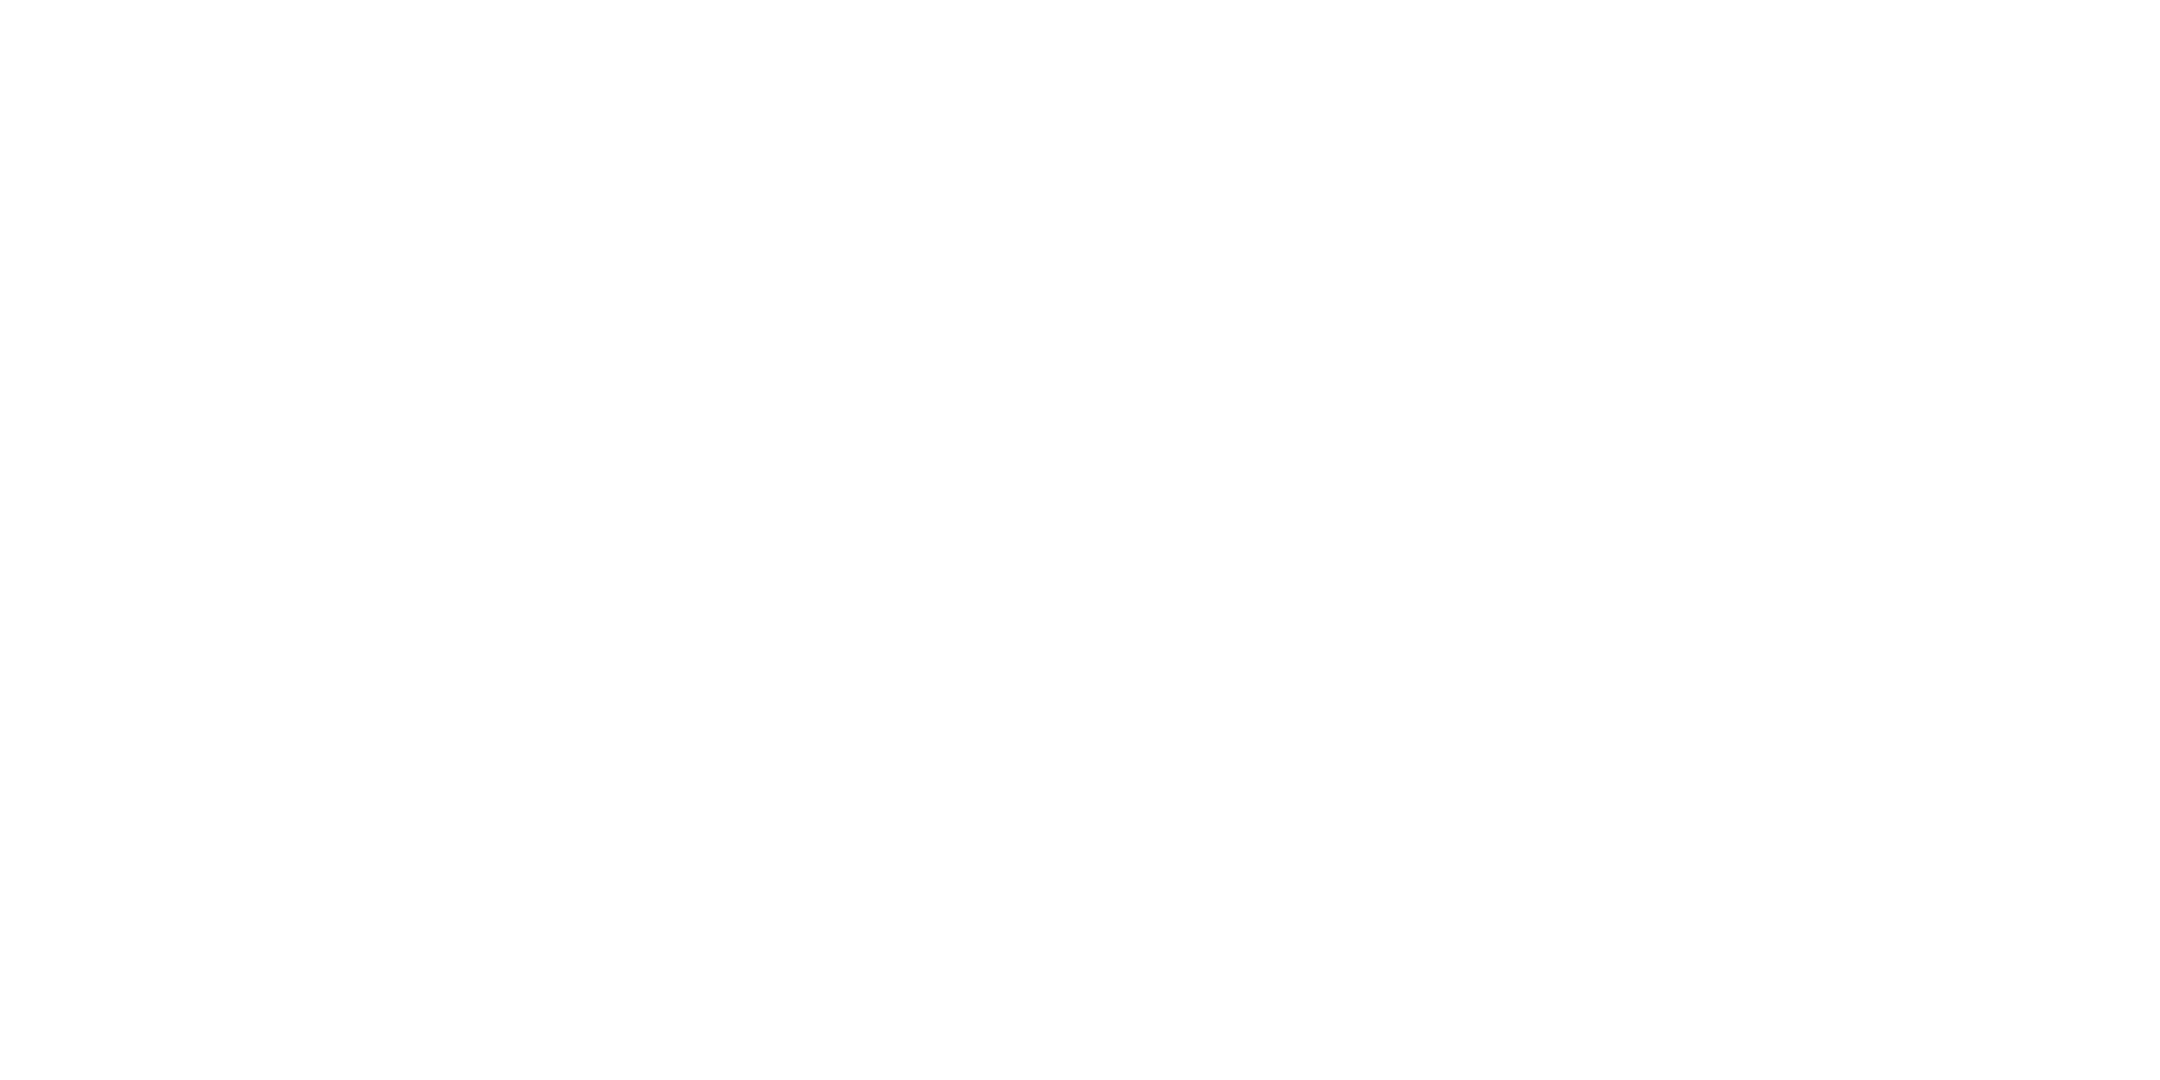

TypeError: 'ndarray' object does not support item assignment

In [5]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(30, 15))

T_s = 60000 
Nep = 10
num_classes = 10
L = flat_x.shape[1]
B = 100 # Batch size
prec = 1e-20 # The smallest number I'm allowing
xi = 0.01

# This is the number of neurons in the second hidden layer
N2 = 200

C_s = 20

df_local_block_tnp(T_s, C_s, flat_x, train_y, Nep, B, prec, xi, N2, fig)

Whelp, I guess that's not happening.  I suppose it's not out of the question for me to convert this entire boi into TensorFlow code, but I'm not going to do that right now.

Alright, the network forced my hand.  Time to try something more extreme.  Each cluster has 100 neurons.  Layer2 also has 100 neurons.  Let's see how this goes.

<IPython.core.display.Javascript object>


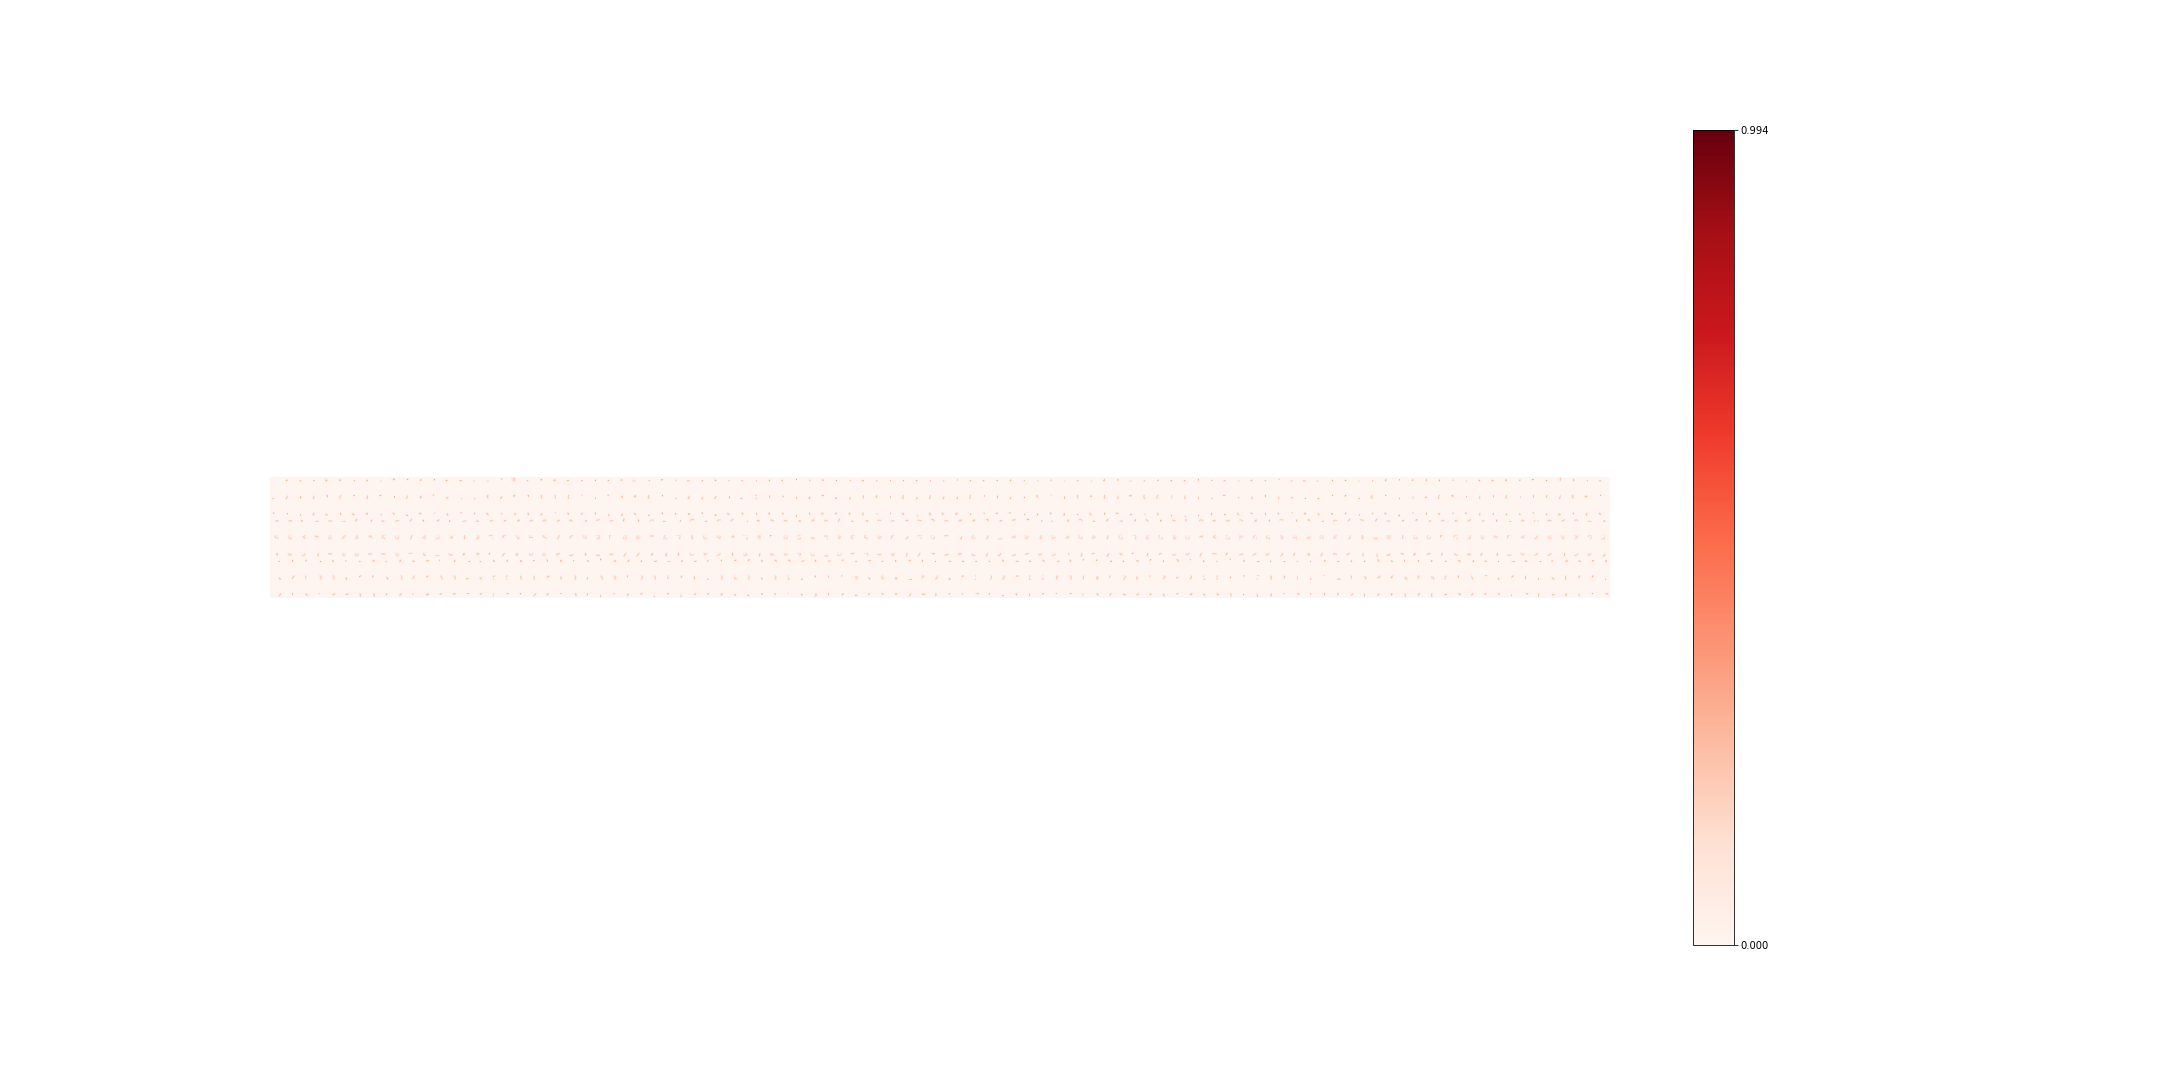

100%|███████████████████████████████████████████████████████████████| 600/600 [07:29<00:00,  1.33it/s]


Accuracy:  68.2%


In [11]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(30, 15))

T_s = 60000 
Nep = 10
num_classes = 10
L = flat_x.shape[1]
B = 100 # Batch size
prec = 1e-20 # The smallest number I'm allowing
xi = 0.01

# This is the number of neurons in the second hidden layer
N2 = 100

C_s = 100

dream_flow_local_block(T_s, C_s, flat_x, train_y, Nep, B, prec, xi, N2, fig)

Well, I think DreamFlow is a bust.  That was kinda my last straw with this architecture.  

## Conclusions

Well my dreams of DreamFlow glory have come to an end.  There simply isn't any notion of symmetry detection.  The network has no clue that two pixels being next to one another have any significance.  In fact, it has the opposite of significance.  They're literally orthogonal.  The question remains.  Could I make them a little less orthogonal?  I'm having some ideas, but they all involve a butt ton of data or computation.  

However, I simply need to figure this out.  Without being overly dramatic, I don't think there's another way.  

To give some more substantial conclusions, I thought that DreamFlow would find substructures in the data, and then use those substructures to make better classifications of the data.  That did not occur.  It literally only did worse than the basic memorization model.  I have to believe that that's because this network has no way of understanding the underlying structure on which this model is predicated.  All of the inputs are entirely orthogonal, so there's just no notion of symmetry what so ever.

Ok, I'm kinda rambling at this point, so I'll just finish up.  Just to be clear, when I say this network has no notion of symmetry, I mean that two objects that look basically the same to me, apart from a small transformation, look entirely different to this current architecture.  It literally has no clue, and it has no way to figure out that they are.  Maybe this is what manifold learning is trying to do.  I don't really know.  But I need to figure out.  

## Next steps

Implement a model that either uses symmetry or finds symmetry to make better classifications.  The end.  